In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import json
import sys
sys.path.append("../")

import anamic

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
from scipy import ndimage
import read_roi
from tqdm.auto import trange
from tqdm.auto import tqdm

pixel_size = 107  # nm/pixel
time_per_frame = 2.33  # s

## Load image and ROIs.

In [3]:
# Open the image and its starting points for fitting
data_dir = Path('/home/hadim/Documents/Code/Postdoc/ij/testdata/anamic')
fname = data_dir / "IRM TEST 2019-06-28-ch1_CROP_XY.tif"

# Open the image
image = tifffile.imread(str(fname))

# Load lines
rois = read_roi.read_roi_zip(fname.with_suffix('.zip'))
roi = list(rois.values())[4]

# Get microtubule tip coordinates
tip_start = np.array([roi['y2'], roi['x2']])
tip_end = np.array([roi['y1'], roi['x1']])

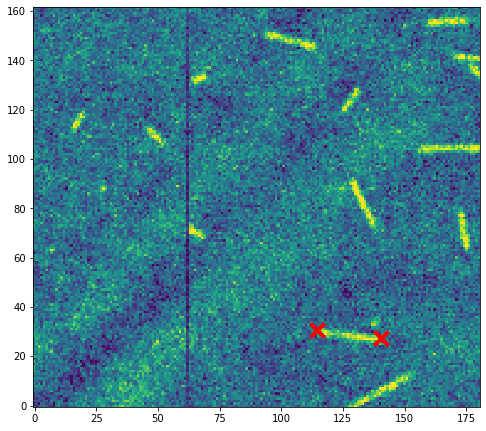

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(image[0], interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')
ax.scatter(tip_start[1], tip_start[0], color='red', s=200, marker="x", lw=4)
ax.scatter(tip_end[1], tip_end[0], color='red', s=200, marker="x", lw=4)

## Define fitting parameters

In [5]:
# Define fitting parameters
args = {}

args['get_thick_line_args'] = {}
args['get_thick_line_args']['length_spacing'] = 1  # pixel
args['get_thick_line_args']['line_thickness'] = 5000 / pixel_size  # pixel
args['get_thick_line_args']['width_spacing'] = 1  # pixel

args['perpendicular_line_fit_args'] = {}
args['perpendicular_line_fit_args']['length_spacing'] = 0.1  # pixel
args['perpendicular_line_fit_args']['fit_threshold'] = 0.15
args['perpendicular_line_fit_args']['continuous_discard'] = False

args['offset_start'] = 2000 / pixel_size  # pixel
args['offset_end'] = 2000 / pixel_size  # pixel

args['tip_fit_args'] = {}
args['tip_fit_args']['length_spacing'] = 0.1  # pixel
args['tip_fit_args']['line_thickness'] = 400 / pixel_size  # pixel
args['tip_fit_args']['width_spacing'] = 0.1  # pixel

## Iterate over all frames and do the fitting.

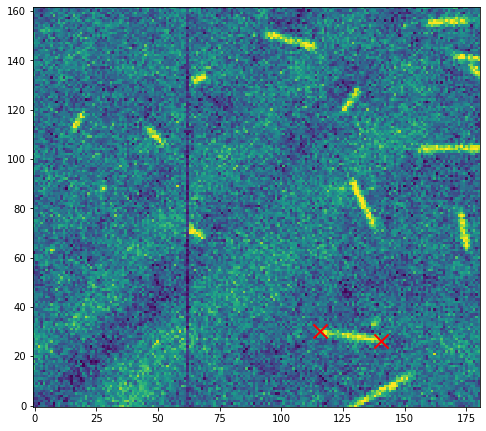

In [6]:
# Use the first frame for the initial fitting.
frame = image[0]

lines = anamic.fitter.get_thick_line(tip_start, tip_end, **args['get_thick_line_args'])

fitted_line = anamic.fitter.perpendicular_line_fit(lines, frame, **args['perpendicular_line_fit_args'])

# Now we fit the best line from those points
a, b = np.polyfit(fitted_line[:, 1], fitted_line[:, 0], deg=1)
new_point1 = np.array([a * fitted_line[0, 1] + b, fitted_line[0, 1]])
new_point2 = np.array([a * fitted_line[-1, 1] + b, fitted_line[-1, 1]])

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(frame, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')
ax.scatter(new_point1[1], new_point1[0], color='red', s=200, marker="x", lw=2)
ax.scatter(new_point2[1], new_point2[0], color='red', s=200, marker="x", lw=2)

In [13]:
data = []
for i in trange(len(image[:])):
  frame = image[i]
  
  # Calculate the vector of the line and its norm
  vec = new_point2 - new_point1

  # Get the coordinates of the points we'll use
  # to for line fitting.
  start_point = anamic.geometry.get_point_from_vector(-vec, new_point2, args['offset_start'])
  end_point = anamic.geometry.get_point_from_vector(vec, new_point2, args['offset_end'])
  line_fit_tips = np.array([start_point, end_point])

  # Fit the tip
  tip_line_fit_results = anamic.fitter.tip_line_fit(line_fit_tips[0], line_fit_tips[1], frame, **args['tip_fit_args'])
  x_profile, y_profile, fit_result, fit_func = tip_line_fit_results
  fit_values = fit_result.values
  fit_values, fit_values['sigma'] * pixel_size

  # Compute x and y tip coordinates.
  mu = fit_values['mu']
  vec = line_fit_tips[1] - line_fit_tips[0]
  y_fitted, x_fitted = anamic.geometry.get_point_from_vector(vec, line_fit_tips[0], mu)

  # Update `new_point2` for the next fit.
  new_point2 = np.array([y_fitted, x_fitted])
  
  # Save the data
  datum = {}
  datum['frame'] = i
  datum['x'] = x_fitted
  datum['y'] = y_fitted
  datum['sigma'] = fit_values['sigma'] * pixel_size
  data.append(datum)
  
data = pd.DataFrame(data)

# Compute length and convert to spatial and temporal values.
init_position = data[['x', 'y']].iloc[0]
data['length'] = np.sqrt(np.sum((data[['x', 'y']] - init_position) ** 2, axis=1))
data['length_um'] = data['length'] * (pixel_size * 1e-3)
data['time_s'] = data['frame'] * time_per_frame
data['time_min'] = data['time_s'] / 60

data.to_csv(fname.with_suffix('.csv'), index=False)

## Load results from CSV

In [7]:
data = pd.read_csv(fname.with_suffix('.csv'))

## Visualize the results.

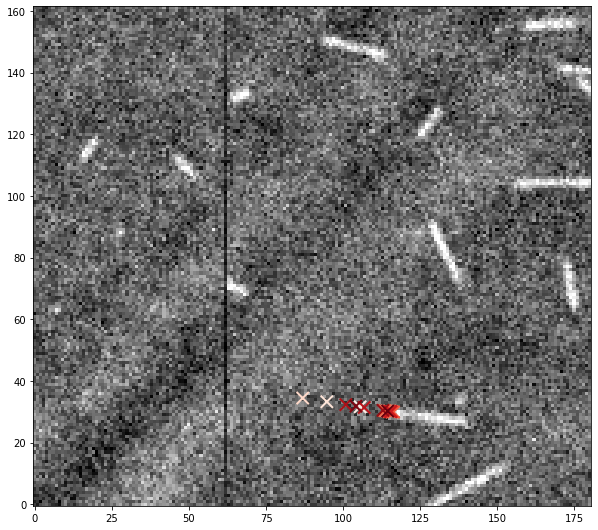

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(image[0], interpolation='none', origin=[0, 0], cmap='gray')
ax.set_aspect('equal')

df = data.iloc[::100]
ax.scatter(df['x'], df['y'], c=df['frame'].values, s=150, marker='x', lw=2, cmap='Reds')

Text(0, 0.5, 'Length (um)')

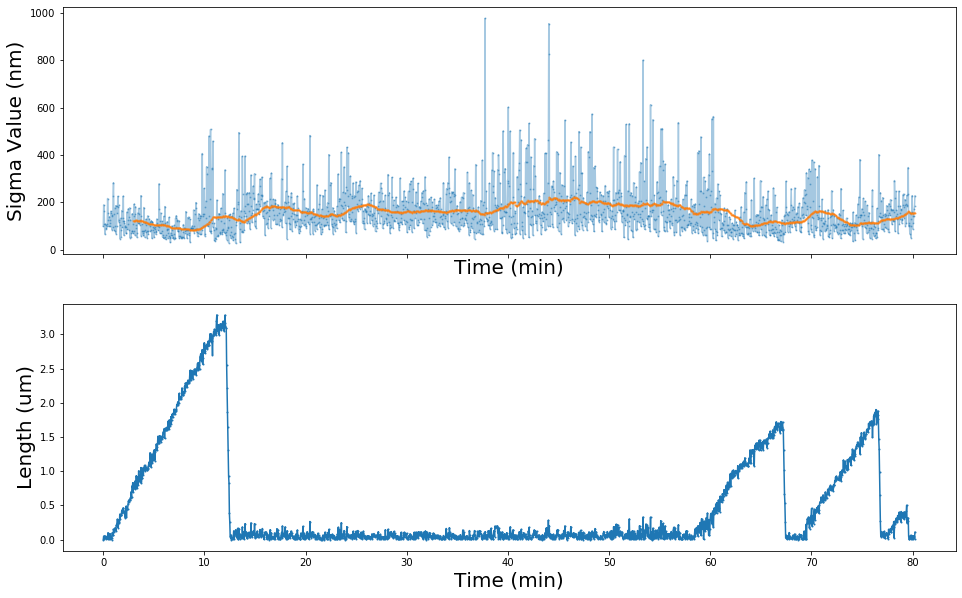

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16, 10), sharex=True)

ax1.plot(data['time_min'], data['sigma'], marker='o', ms=1, alpha=0.4)

# Rolling average.
rolling_window_s = 3 * 60  # s
rolling_window = int(rolling_window_s / time_per_frame)
rolling_values = data['sigma'].rolling(rolling_window).mean()
ax1.plot(data['time_min'], rolling_values, marker='o', ms=1, alpha=0.4)

ax1.set_xlabel('Time (min)', fontsize=20)
ax1.set_ylabel('Sigma Value (nm)', fontsize=20)

ax2.plot(data['time_min'], data['length_um'], marker='o', ms=1)
ax2.set_xlabel('Time (min)', fontsize=20)
ax2.set_ylabel('Length (um)', fontsize=20)

## Make movie with overlay

In [14]:
import imageio

with imageio.get_writer(fname.with_suffix('.mp4'), mode='I') as f:
  
  df = data.iloc[:]
  for _, row in tqdm(df.iterrows(), total=len(df)):
    frame = image[int(row['frame'])]

    fig, ax = plt.subplots(figsize=(6.08, 6.08), dpi=100)
    ax.imshow(frame, interpolation='none', origin=[0, 0], cmap='gray')
    ax.set_aspect('equal')
    ax.scatter(row['x'], row['y'], color='none', edgecolors='red', s=500, marker='o', lw=2)
    
    fig.canvas.draw()
    buffer_image = np.array(fig.canvas.renderer.buffer_rgba())
    f.append_data(buffer_image)
    
    fig.clear()
    plt.close('all')

In [ ]:
import base64
from IPython import display
video = open(fname.with_suffix('.mp4'), "rb").read()
encoded = base64.b64encode(video)
display.HTML(data=f'<video width=600 controls><source src="data:video/mp4;base64,{encoded.decode("ascii")}" type="video/mp4" /></video>')

## Build kymograph

In [60]:
offset_start = 4000 / pixel_size  # pixel
offset_end = 100 / pixel_size  # pixel

vec = data.iloc[-1][['x', 'y']] - data.iloc[0][['x', 'y']]

point1 = data.loc[data['length'].idxmin()][['x', 'y']]
point1 = anamic.geometry.get_point_from_vector(-vec, point1, offset_start)
point1 = point1[::-1]

point2 = data.loc[data['length'].idxmax()][['x', 'y']]
point2 = anamic.geometry.get_point_from_vector(vec, point2, offset_end)
point2 = point2[::-1]

kymograph = []
for i in trange(len(image[:])):
  frame = image[i]
  _, profile = anamic.fitter.line_profile(frame, point1, point2, line_thickness=0, normalized_intensities=False)
  kymograph.append(profile)
kymograph = np.array(kymograph)

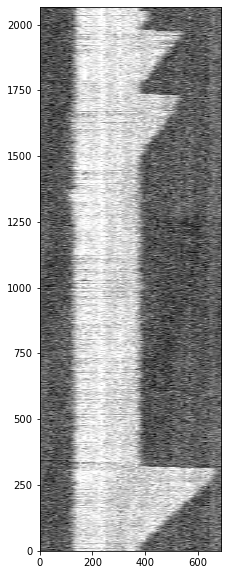

In [61]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(kymograph, interpolation='none', origin=[0, 0], cmap='gray')
ax.set_aspect('equal')